In [1]:
!unzip Recycling_Plastic.zip -d /content/


Archive:  Recycling_Plastic.zip
  inflating: /content/seven_plastics/1_polyethylene_PET/85943598-ec9b-4da5-9221-8c32b5742e72.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/AORA7148.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/BBOZ2526.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/BIGI9753.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/FQCK7421.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/HSBT4561.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6263.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6268.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6269.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6271.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6272.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6308.jpg  
  inflating: /content/seven_plastics/1_polyethylene_PET/IMG_6328.jpg  
  inflating: /con

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
img_height, img_width = IMG_SIZE = (200, 200)
batch_size = 32

data_dir = "/content/seven_plastics"

In [12]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 685 files belonging to 8 classes.
Using 617 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 685 files belonging to 8 classes.
Using 68 files for validation.


In [14]:
# List the classes

class_names = train_ds.class_names
print(class_names)

['1_polyethylene_PET', '2_high_density_polyethylene_PE-HD', '3_polyvinylchloride_PVC', '4_low_density_polyethylene_PE-LD', '5_polypropylene_PP', '6_polystyrene_PS', '7_other_resins', '8_no_plastic']


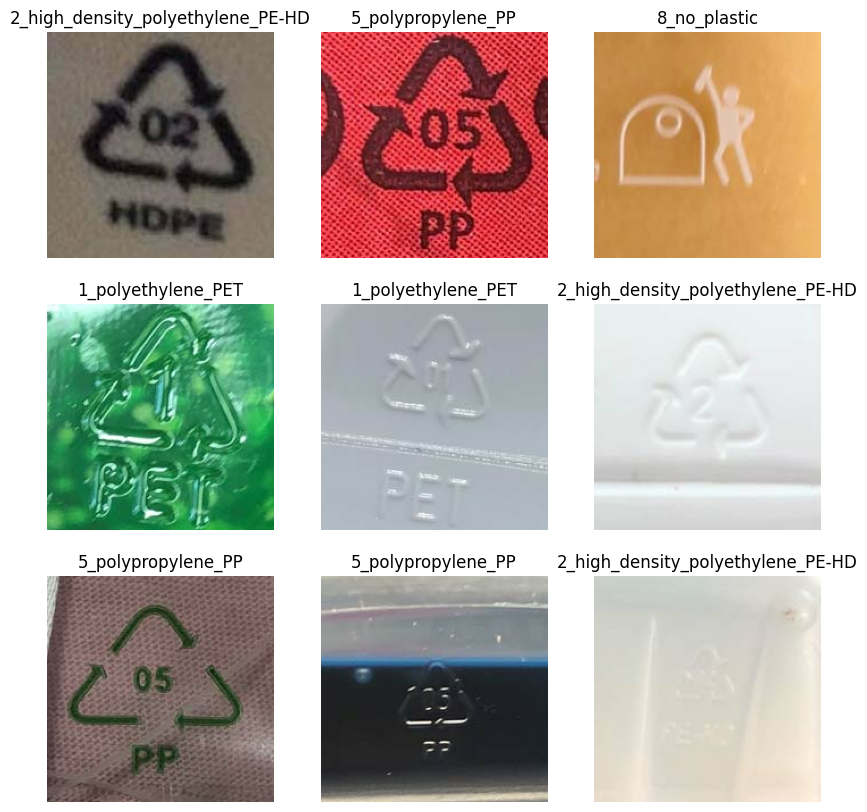

In [15]:
# Get a look at what we are training on

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [16]:
# Prefetch images to memory, to make training faster

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomZoom(0.2),
])


In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

<ipython-input-20-166d6a4a06f6>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [22]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [24]:
num_classes = len(class_names)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [25]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          10,248 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(val_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.1096 - loss: 2.6420


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.61
initial accuracy: 0.12


In [30]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.2518 - loss: 2.1765 - val_accuracy: 0.3235 - val_loss: 1.8379
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3789 - loss: 1.6909 - val_accuracy: 0.4853 - val_loss: 1.6391
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4614 - loss: 1.5036 - val_accuracy: 0.5147 - val_loss: 1.4912
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4470 - loss: 1.4633 - val_accuracy: 0.5294 - val_loss: 1.4356
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5465 - loss: 1.2431 - val_accuracy: 0.5147 - val_loss: 1.4184
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5280 - loss: 1.2698 - val_accuracy: 0.5735 - val_loss: 1.3238
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5816 - loss: 1.1614 - val_accuracy: 0.5735 - val_loss: 1.2896
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5935 - loss: 1.0666 - val_accuracy: 0

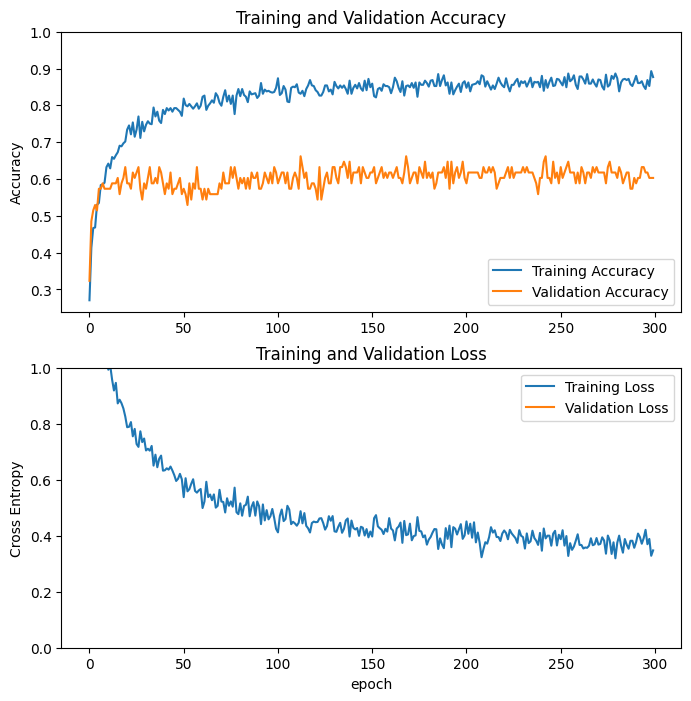

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
export_path = "/content/saved_model.keras"
model.save(export_path)

print(f"Model saved at: {export_path}")


Model saved at: /content/saved_model.keras


In [38]:
# Understand our Input data files. For example,
# how many files are there, what are the resolutions

import os
from collections import Counter
import PIL
import PIL.Image

for dirname, _, filenames in os.walk(data_dir):
    c = Counter()

    for filename in filenames:
        with PIL.Image.open(str(os.path.join(dirname, filename))) as im:
            c.update([im.size])

    print(os.path.basename(dirname))

    for key, value in c.items():
        print(key, value)

    print()


#6_polystyrene_PS/MNIV8565.jpg
#/6_polystyrene_PS/IMG_E6426.jpg

seven_plastics

8_no_plastic
(200, 200) 71
(200, 192) 1
(180, 200) 1
(200, 199) 2
(199, 200) 1
(200, 176) 1
(150, 200) 1
(200, 130) 1

3_polyvinylchloride_PVC
(200, 200) 24

6_polystyrene_PS
(200, 200) 37
(200, 199) 1
(199, 200) 1

5_polypropylene_PP
(200, 200) 171
(199, 200) 8
(200, 199) 12
(200, 198) 1

4_low_density_polyethylene_PE-LD
(200, 200) 89
(200, 199) 1

2_high_density_polyethylene_PE-HD
(200, 200) 72
(199, 200) 4

7_other_resins
(200, 200) 58
(199, 200) 3
(198, 200) 2
(200, 199) 1

1_polyethylene_PET
(200, 200) 110
(200, 199) 5
(199, 200) 6

